In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import scipy as sp
import numpy as np
import anndata
import pySingleCellNet as pySCN
sns.set_style('white')

In [4]:
# read in data
adata_mcm_raw=sc.read_h5ad('direct_conversion_subsampled_5k_raw.h5ad')
adata_tabmuris=sc.read_h5ad('TM_FACS_heart.h5ad')

In [5]:
adata_mcm_raw.obs['Timepoint (days)']=adata_mcm_raw.obs['batch'].map({'1':'-1','2':'1','3':'2','4':'3','5':'7','6':'14'})

In [6]:
#qc metrics for oldhsc
adata_mcm_raw.var['mt']= adata_mcm_raw.var_names.str.startswith(("mt-"))
adata_mcm_raw.var['ribo'] = adata_mcm_raw.var_names.str.startswith(("Rps","Rpl"))
sc.pp.calculate_qc_metrics(adata_mcm_raw, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

In [7]:
genesTrain = adata_tabmuris.var_names
genesQuery = adata_mcm_raw.var_names
cgenes = genesTrain.intersection(genesQuery)
#around 14k genes remanining

In [8]:
#subsetting for common genes
adata_reference_cgene = adata_tabmuris[:,cgenes]
adata_mcm_raw = adata_mcm_raw[:,cgenes].copy()

#following the pyscCellNet vignette on github. im guessing cells with more than 500 
adata_mcm_classifier = adata_mcm_raw[adata_mcm_raw.obs["n_genes_by_counts"]>=500,:].copy()




In [9]:
adata_reference_cgene.obs['cell_ontology_class'].unique()

['endothelial cell', 'leukocyte', 'fibroblast', 'myofibroblast cell', 'endocardial cell', 'cardiac muscle cell', 'smooth muscle cell']
Categories (7, object): ['cardiac muscle cell', 'endocardial cell', 'endothelial cell', 'fibroblast', 'leukocyte', 'myofibroblast cell', 'smooth muscle cell']

In [10]:
expTrain, expVal = pySCN.splitCommonAnnData(adata_reference_cgene, ncells=200,dLevel='cell_ontology_class')



/Users/yashsonthalia/opt/anaconda3/lib/python3.7/site-packages/pySingleCellNet/utils.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[cellid] = adata.obs.index


cardiac muscle cell : 
133
leukocyte : 
523
myofibroblast cell : 
178
endothelial cell : 
1177
fibroblast : 
2119
endocardial cell : 
165
smooth muscle cell : 
42


In [11]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 100,
                                           nTrees = 1000 ,nTopGenePairs = 100, dLevel = 'cell_ontology_class', 
                                           stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  731  classification genes

cardiac muscle cell
endocardial cell
endothelial cell
fibroblast
leukocyte
myofibroblast cell
smooth muscle cell
There are 690 top gene pairs

Finished pair transforming the data



<Figure size 6000x4000 with 0 Axes>

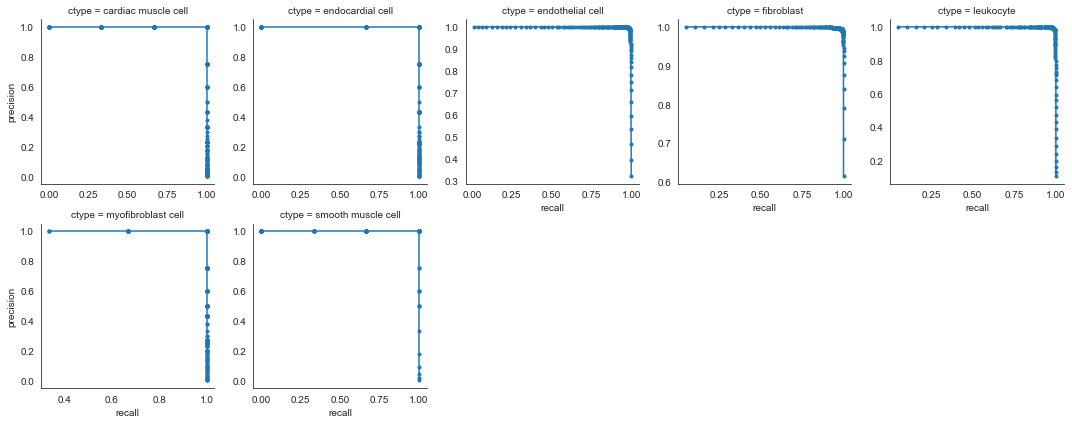

<Figure size 432x288 with 0 Axes>

In [12]:
#classifier on held out test set
plt.figure(dpi=1000)
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)
assessment =  pySCN.assess_comm(expTrain, adVal, resolution = 0.005, nRand = 0, dLevelSID = "cell", classTrain = "cell_ontology_class", classQuery = "cell_ontology_class")

pySCN.plot_PRs(assessment)
plt.show()
plt.savefig("pyscn_testsetprc.png") #save as png

In [13]:
#use classifier on old hsc data
adata_mcm_classified = pySCN.scn_classify(adata_mcm_classifier, cgenesA, xpairs, tspRF, nrand = 0)



In [14]:
props={}
for i in adata_mcm_classified.obs['Timepoint (days)'].unique():
    props[i]={}
    for j in adata_mcm_classified[adata_mcm_classified.obs['Timepoint (days)']==i].obs['SCN_class'].unique():
        props[i][j]=sum(adata_mcm_classified[adata_mcm_classified.obs['Timepoint (days)']==i].obs['SCN_class']==j)

In [15]:
scn_calls=pd.DataFrame(props).fillna(0)
scn_calls.update(scn_calls.div(scn_calls.sum(axis=0),axis=1))
scn_calls=scn_calls[['-1','1','2','3','7','14']]

In [16]:
scn_calls

,-1,1,2,3,7,14
cardiac muscle cell,0.000000,0.000000,0.003415,0.024605,0.078541,0.453917
rand,0.717358,0.884422,0.856557,0.838313,0.697055,0.493088
leukocyte,0.076805,0.087102,0.101093,0.094903,0.165498,0.050691
fibroblast,0.204301,0.026801,0.036202,0.034271,0.053296,0.002304
endothelial cell,0.001536,0.000000,0.000000,0.000000,0.001403,0.000000
endocardial cell,0.000000,0.001675,0.002732,0.007909,0.004208,0.000000


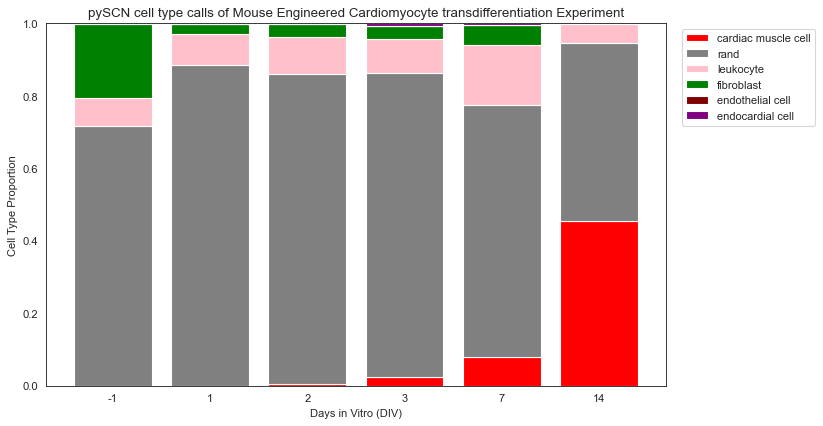

In [17]:
plt.figure(figsize=(10, 6), dpi=80)

plt.bar(scn_calls.columns,scn_calls.loc['cardiac muscle cell'],color='red')
plt.bar(scn_calls.columns, scn_calls.loc['rand'], bottom=scn_calls.loc['cardiac muscle cell'], color='grey')
plt.bar(scn_calls.columns, scn_calls.loc['leukocyte'], bottom=scn_calls.loc['cardiac muscle cell']+scn_calls.loc['rand'], color='pink')
plt.bar(scn_calls.columns, scn_calls.loc['fibroblast'], bottom=scn_calls.loc['leukocyte']+scn_calls.loc['cardiac muscle cell']+scn_calls.loc['rand'], color='green')
plt.bar(scn_calls.columns, scn_calls.loc['endothelial cell'], bottom=scn_calls.loc['leukocyte']+scn_calls.loc['cardiac muscle cell']+scn_calls.loc['rand']+scn_calls.loc['fibroblast'], color='maroon')
plt.bar(scn_calls.columns, scn_calls.loc['endocardial cell'], bottom=scn_calls.loc['leukocyte']+scn_calls.loc['cardiac muscle cell']+scn_calls.loc['rand']+scn_calls.loc['fibroblast']+scn_calls.loc['endothelial cell'], color='purple')


plt.legend(["cardiac muscle cell", "rand", "leukocyte", "fibroblast",'endothelial cell','endocardial cell'],loc='upper right',bbox_to_anchor=(1.25, 1.0))
plt.xlabel('Days in Vitro (DIV)')
plt.ylabel('Cell Type Proportion')
plt.title('pySCN cell type calls of Mouse Engineered Cardiomyocyte transdifferentiation Experiment')
plt.savefig("pyscn_stackedbarplot.png") #save as png
